**"We certify that the code and data in this assignment were generated independently, using
only the tools and resources defined in the course and that I/we did not receive any external
help, coaching or contributions during the production of this work."**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [2]:
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self):
    self.observation_space = spaces.Discrete(16)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = 20

  def reset(self):
    self.timestep = 0
    self.state = np.zeros((4, 4))
    #x,y = np.random.randint(4),np.random.randint(4)
    self.agent_pos = [0,0]#[x, y] #starting position of the agent(random starting position)
    self.orc_pos = [3,0] #position of Oracle
    self.morp_pos = [0,2] #position of Morpheus
    self.esc_pos = [3, 3] #goal position
    self.smi_pos = [2,3] #position of Agent Smith

    #Setting different colours to differentiate various positions
    self.state[tuple(self.agent_pos)] = 2
    self.state[tuple(self.morp_pos)] = 3
    self.state[tuple(self.orc_pos)] = 4
    self.state[tuple(self.esc_pos)] = 6
    self.state[tuple(self.smi_pos)] = 5

    #reset visit count to reward states
    self.m_flag,self.s_flag,self.o_flag = 0,0,0

    observation = self.state.flatten()
    pos = self.agent_pos
    return  tuple(pos)

  def step(self, action):
    if action == 0:#down
      self.agent_pos[0] += 1
    if action == 1:#up
      self.agent_pos[0] -= 1
    if action == 2:#right
      self.agent_pos[1] += 1
    if action == 3:#left
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos, 0, 3)
    self.state = np.zeros((4,4))

    self.state[tuple(self.agent_pos)] = 2
    self.state[tuple(self.morp_pos)] = 3
    self.state[tuple(self.orc_pos)] = 4
    self.state[tuple(self.esc_pos)] = 6
    self.state[tuple(self.smi_pos)] = 5

    observation = self.state.flatten()
    #Info contains the details of a state
    info = ""
    reward = -0.25
    terminal = False
    if (self.agent_pos == (0,0)).all():
      reward = 0
      
      

    if (self.agent_pos == self.esc_pos).all():
      reward = 10
      terminal = True
      info = "Congrats you have escaped the Matrix"
    
    
    if (self.agent_pos == self.morp_pos).all() and self.m_flag == 0:
      reward = 5
      info = "Meet Morpheus"
      self.m_flag = 1

   
    if (self.agent_pos == self.orc_pos).all() and self.o_flag == 0:
      reward = 2
      info = "Meet Oracle"
      self.o_flag = 1

  
    if (self.agent_pos == self.smi_pos).all() and self.s_flag == 0:
      reward = -10
      info = "Oh no!, you have encountered with Agent Smith"
      self.s_flag = 1

    self.timestep += 1
    limit = True if self.timestep >= self.max_timesteps else False

    if terminal or limit:
      done =True
    else:
      done = False
    
    pos = self.agent_pos
    return tuple(pos), reward, done, info

  def render(self):
    plt.text(-0.3,3.1,"Oracle")
    plt.text(2.8,3.1,"Exit")
    plt.text(2.7,2.2,"Agent\nSmith")
    plt.text(1.5,0,"Morpheus")
    
    plt.imshow(self.state,cmap="Greens")

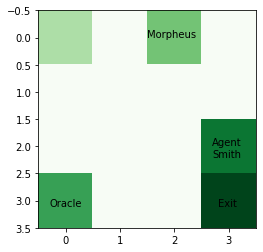

In [3]:
env = GridEnvironment()
obs = env.reset()
env.render()

In [4]:
import gym, os
from itertools import count
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import math

In [5]:
torch.manual_seed(2002882284479475884)

In [6]:

class Actor(nn.Module):
    
    def __init__(self):
        super(Actor, self).__init__()
        # input - 2
        # output - 3 (action probabilities)
        self.fc1 = nn.Linear(2, 20)
        self.fc5 = nn.Linear(20,4)
       

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc5(x), dim = -1)
        
        return x

In [8]:
class Critic(nn.Module):
  
    def __init__(self):
        super(Critic, self).__init__()
        # input - 2
        # output - 3 (action probabilities)
        self.fc1 = nn.Linear(2, 20)
        self.fc5 = nn.Linear(20,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc5(x))
        
        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [14]:
actor = Actor().to(device)
critic = Critic().to(device)
#target_critic = Critic().to(device)

max_episodes= 2000+1
env.reset()
list_r=[]

log_probs = []
values = []
rewards = []
masks = []

update = 15
gamma = 0.9

lr_a = 0.001
lr_c = 0.001

optimizer_a = torch.optim.SGD(actor.parameters(), lr= lr_a, momentum=0.9)
optimizer_c = torch.optim.SGD(critic.parameters(), lr= lr_c,momentum=0.9)

#critic_loss = torch.nn.MSELoss()
#actor_loss = torch.nn.CrossEntropyLoss()


for i in range(max_episodes):
    done=False
    state= env.reset()
    r=0
    u = 0 
    d = 1 
    log_probs = []
    values = []
    rewards = []
    masks = []
    episode_entropy = 0
   
    loss_a_list = []
    actor_losses= 0
    q_val = 0
    while not done:
      
      value = critic(torch.Tensor(state))
      act_prob = actor(torch.Tensor(state))

        #detaching to numbers for calculation
      value = value.detach().numpy()[0]
      prob = act_prob.detach().numpy() 
        
      #sample an action
      action = torch.multinomial(act_prob,1 ).detach().numpy()[0]

      log_prob = torch.log(act_prob.squeeze(0)[action])

      entropy = -np.sum(np.mean(prob) * np.log(prob))

      #pass action in env
      next_state,reward,done, info = env.step(action)
      r+=reward


      rewards.append(reward)
      values.append(value)
      log_probs.append(log_prob)
      episode_entropy += entropy
      state = next_state

      qval = critic(torch.Tensor(state))
      qval = qval.detach().numpy()[0]

    qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
      qval = rewards[t] + gamma * qval
      qvals[t] = qval

    values = torch.FloatTensor(values)
    qvals = torch.FloatTensor(qvals)
    log_probs = torch.stack(log_probs)

    advantage = qvals - values

    actor_loss = (-log_probs * advantage).mean() + 0.001 * episode_entropy
    critic_loss = 0.5 * advantage.pow(2).mean()  + 0.001 * episode_entropy
    critic_loss.requires_grad =True

    optimizer_a.zero_grad()
    optimizer_c.zero_grad()

    actor_loss.backward()
    critic_loss.backward()

    optimizer_a.step()
    optimizer_c.step()   
    

    list_r.append(r)
    if i%10 == 0:
      print("Episode: ",i," Last avg reward: ",sum(list_r[-10:])/10)


Episode:  0  Last avg reward:  0.275
Episode:  10  Last avg reward:  -3.175
Episode:  20  Last avg reward:  0.85
Episode:  30  Last avg reward:  -1.1
Episode:  40  Last avg reward:  -3.0
Episode:  50  Last avg reward:  -3.025
Episode:  60  Last avg reward:  -1.25
Episode:  70  Last avg reward:  -2.225
Episode:  80  Last avg reward:  -1.325
Episode:  90  Last avg reward:  0.55
Episode:  100  Last avg reward:  -0.925
Episode:  110  Last avg reward:  -2.45
Episode:  120  Last avg reward:  -1.25
Episode:  130  Last avg reward:  -0.75
Episode:  140  Last avg reward:  -2.45
Episode:  150  Last avg reward:  2.825
Episode:  160  Last avg reward:  0.15
Episode:  170  Last avg reward:  2.25
Episode:  180  Last avg reward:  3.15
Episode:  190  Last avg reward:  6.625
Episode:  200  Last avg reward:  -0.1
Episode:  210  Last avg reward:  4.1
Episode:  220  Last avg reward:  6.875
Episode:  230  Last avg reward:  8.275
Episode:  240  Last avg reward:  7.45
Episode:  250  Last avg reward:  8.125
Epi

In [15]:
torch.seed()
#2002882284479475884
#13879523845109458094

13879523845109458094

In [16]:
#torch.save(actor.state_dict(), 'actor.pt')
#torch.save(critic.state_dict(), 'critic.pt')

10.1325

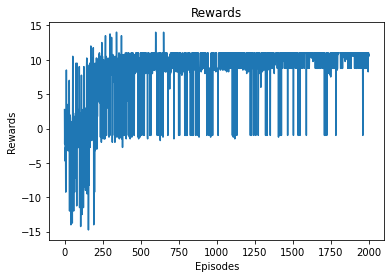

In [17]:
plt.plot(list_r)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Rewards")
sum(list_r[-100:])/100

In [19]:
actor.load_state_dict(torch.load('actor_GW.pt'))

<All keys matched successfully>

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

reach


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

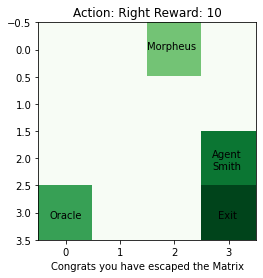

<IPython.core.display.Javascript object>

In [20]:
from google.colab import widgets
import time
output_grid = widgets.Grid(1,1)
env = GridEnvironment()
action_txt = {0:"Down",1:"Up",2:"Right",3:"Left"}
reward_eval_q_s = [] #evaluation rewards for q learning on stochastic environment
goals = []

for episode in range(10):
  state = env.reset()
  with output_grid.output_to(0,0):
    output_grid.clear_cell()
    #plt.figure()
    plt.title("*****Episode: "+str(episode+1)+"*****")
    env.render()
  time.sleep(0.1)
  done = False
  reward_pe =0 

  goal = 0
  
  while not done:
    action_probs = actor(torch.Tensor([state]).to(device))
    action = torch.multinomial(action_probs[0],1) # Exploit learned values
    #print(action_probs)
    #action = torch.argmax(action_probs[0] )
    

    next_state, reward, done, info = env.step(action) 
    
    if info == "Congrats you have escaped the Matrix":
      print("reach")
      goal+=1
      
    reward_pe+=reward
    a = 'Action: '+str(action_txt[action.item()])+' Reward: '+str(reward)
    with output_grid.output_to(0,0):
      output_grid.clear_cell()
      #plt.figure()
      plt.title(a)
      plt.xlabel(info)
      env.render()
    time.sleep(0.1)
    state = next_state

  reward_eval_q_s.append(reward_pe)
  goals.append(goal)
    



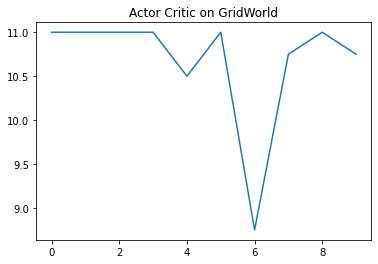

In [21]:
plt.plot(reward_eval_q_s, )
plt.title("Actor Critic on GridWorld")
plt.show()

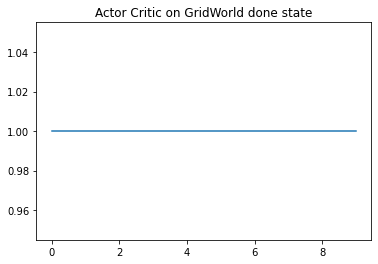

In [22]:
plt.plot(goals,'-')
plt.title("Actor Critic on GridWorld done state")
plt.show()

**Reference:**

- https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f